In [1]:
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict
from recsys.models import WD
from recsys.data.movielens import MovielensFeatureDataset
from recsys.metrics.rank import hit_ratio_at_k, ndcg_at_k, mrr_at_k
from sklearn.metrics import roc_auc_score

In [2]:
with open("movielens/processed/num_sparse_features.json", "r") as f:
    num_sparse_features = json.load(f)
    
with open("movielens/processed/dense_features.json", "r") as f:
    dense_features = json.load(f)
num_dense_features = len(dense_features)
    
with open("movielens/processed/experiment_group.json", "r") as f:
    experiment_group = json.load(f)
experiment_group[WD.model_name] = []

train = pd.read_parquet("movielens/processed/train.parquet")
test = pd.read_parquet("movielens/processed/test.parquet")

In [3]:
# Cross Feature
cross_prefix = "cross"
cross_features = [["gender", "genre"], ["gender", "occupation"]]
for cross_feature in cross_features:
    corss_feature_name = f"{cross_prefix}_{cross_feature[0]}_{cross_feature[1]}"
    num_sparse_features[corss_feature_name] = num_sparse_features[cross_feature[0]] * num_sparse_features[cross_feature[1]]
    train[corss_feature_name] = (
        train[cross_feature[0]] * (num_sparse_features[cross_feature[1]]) 
        + train[cross_feature[1]]
    )

    test[corss_feature_name] = (
        test[cross_feature[0]] * (num_sparse_features[cross_feature[1]]) 
        + test[cross_feature[1]]
    )

In [4]:
# Training Hyperparameter
batch_size = 64
latent_dim = 16
hidden_layers = [32, 32, 32]
lr = 1e-3
epochs = 10

# Define Dataset
train_ds = MovielensFeatureDataset(train, list(num_sparse_features.keys()), dense_features)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = MovielensFeatureDataset(test, list(num_sparse_features.keys()), dense_features)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test["item_id"].nunique(), shuffle=False)

device = torch.device("cpu")
model = WD(num_sparse_features, num_dense_features, latent_dim, hidden_layers)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

WideAndDeep(
  (wide): Wide(
    (linear_arch): Linear(in_features=2748, out_features=1, bias=False)
  )
  (deep): Deep(
    (sparse_arch): ModuleDict(
      (user_id): Embedding(943, 16)
      (item_id): Embedding(1682, 16)
      (gender): Embedding(2, 16)
      (occupation): Embedding(21, 16)
      (genre): Embedding(19, 16)
    )
    (dense_arch): Linear(in_features=1, out_features=16, bias=True)
    (mlp): Sequential(
      (0): Linear(in_features=96, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=1, bias=False)
    )
  )
)


In [5]:
# Train MF
history = defaultdict(list)
model.train()
auc = 0
for epoch in range(epochs):
    total_loss = 0
    all_labels = []
    all_preds = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for sparse_features, dense_features, labels in pbar:
        sparse_features = {k: v.to(device) for k, v in sparse_features.items()}
        dense_features = dense_features.to(device)
        labels = labels.unsqueeze(1).to(device)

        
        # forward
        logits = model(sparse_features, dense_features)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)

        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # metrics
        total_loss += loss.item()
        probs = logits.sigmoid().detach().cpu().numpy()
        all_preds.extend(probs.flatten())
        all_labels.extend(labels.detach().cpu().numpy().flatten())
        
        # tqdm update
        pbar.set_postfix(
            logloss=loss.item(),
            auc=f"{auc:.4f}"
            
        )

        
    avg_loss = total_loss / len(train_loader)
    acc = ((np.array(all_preds) > 0.5) == np.array(all_labels)).mean()
    auc = roc_auc_score(all_labels, all_preds)
    history["accuracy"].append(acc)
    history["auroc"].append(auc)
    history["logloss"].append(avg_loss)
    
    pbar.set_postfix(
        logloss=f"{avg_loss:.4f}",
        auc=f"{auc:.4f}"
    )
    pbar.refresh()

Epoch 1/10: 100%|█| 5747/5747 [00:17<00:00, 320.87it/s, auc=0.0000, logloss=0.27
Epoch 2/10: 100%|█| 5747/5747 [00:19<00:00, 299.15it/s, auc=0.7753, logloss=0.26
Epoch 3/10: 100%|█| 5747/5747 [00:19<00:00, 290.88it/s, auc=0.8312, logloss=0.42
Epoch 4/10: 100%|█| 5747/5747 [00:18<00:00, 305.00it/s, auc=0.8419, logloss=0.36
Epoch 5/10: 100%|█| 5747/5747 [00:18<00:00, 308.89it/s, auc=0.8499, logloss=0.35
Epoch 6/10: 100%|█| 5747/5747 [00:19<00:00, 294.89it/s, auc=0.8566, logloss=0.20
Epoch 7/10: 100%|█| 5747/5747 [00:20<00:00, 284.69it/s, auc=0.8628, logloss=0.38
Epoch 8/10: 100%|█| 5747/5747 [00:19<00:00, 288.77it/s, auc=0.8686, logloss=0.41
Epoch 9/10: 100%|█| 5747/5747 [00:19<00:00, 298.12it/s, auc=0.8744, logloss=0.35
Epoch 10/10: 100%|█| 5747/5747 [00:20<00:00, 286.34it/s, auc=0.8795, logloss=0.2


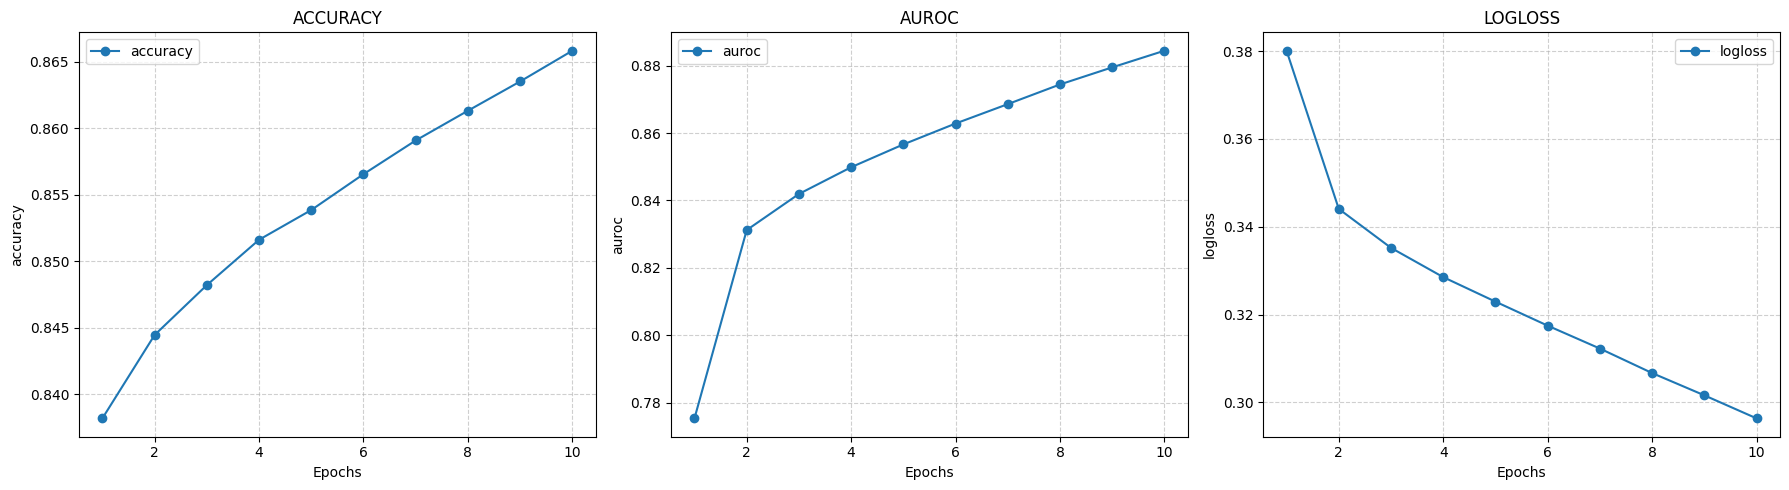

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, metrics in enumerate(history):
    ax = axes[i]

    ax.plot(range(1, epochs+1), history[metrics], marker="o", label=metrics)
    ax.set_title(metrics.upper())
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metrics)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [7]:
# Recommendation
user_recommendations = {}
model.eval()
with torch.no_grad():
    pbar = tqdm(test_loader, desc="Recommend")
    
    for sparse_features, dense_features, _ in pbar:
        # batch: user 1명당 모든 item씩 나오도록 되어 있음
        user_id = sparse_features["user_id"][0].item()
        sparse_features = {k: v.to(device) for k, v in sparse_features.items()}
        dense_features = dense_features.to(device)

        # forward
        logits = model(sparse_features, dense_features)
        
        indices = logits.flatten().argsort(descending=True)
        
        user_recommendations[user_id] = indices.detach().cpu().numpy()
        
        pbar.set_postfix(user_id=user_id)
        

Recommend: 100%|█████████████████| 943/943 [00:16<00:00, 57.56it/s, user_id=942]


In [8]:
ks = [5, 10, 15, 20]
hr = defaultdict(float)
ndcg = defaultdict(float)
mrr = defaultdict(float)
_test = test[test["rating"]==1]
for line in _test.itertuples():
    user_id, item_id = line.user_id, line.item_id
    item_id = np.int64(item_id)
    recs = user_recommendations[user_id]
    experiment_group[model.model_name] = recs

    # calculate
    for k in ks:
        for m in experiment_group:
            hr[f"{m}@{k}"] += hit_ratio_at_k(experiment_group[m], item_id, k)
            ndcg[f"{m}@{k}"] += ndcg_at_k(experiment_group[m], item_id, k)
            mrr[f"{m}@{k}"] += mrr_at_k(experiment_group[m], item_id, k)
    
    
hr = {k: np.round(v/len(_test), 4) for k,v in hr.items()}
ndcg = {k: np.round(v/len(_test), 4) for k,v in ndcg.items()}
mrr = {k: np.round(v/len(_test), 4) for k,v in mrr.items()}

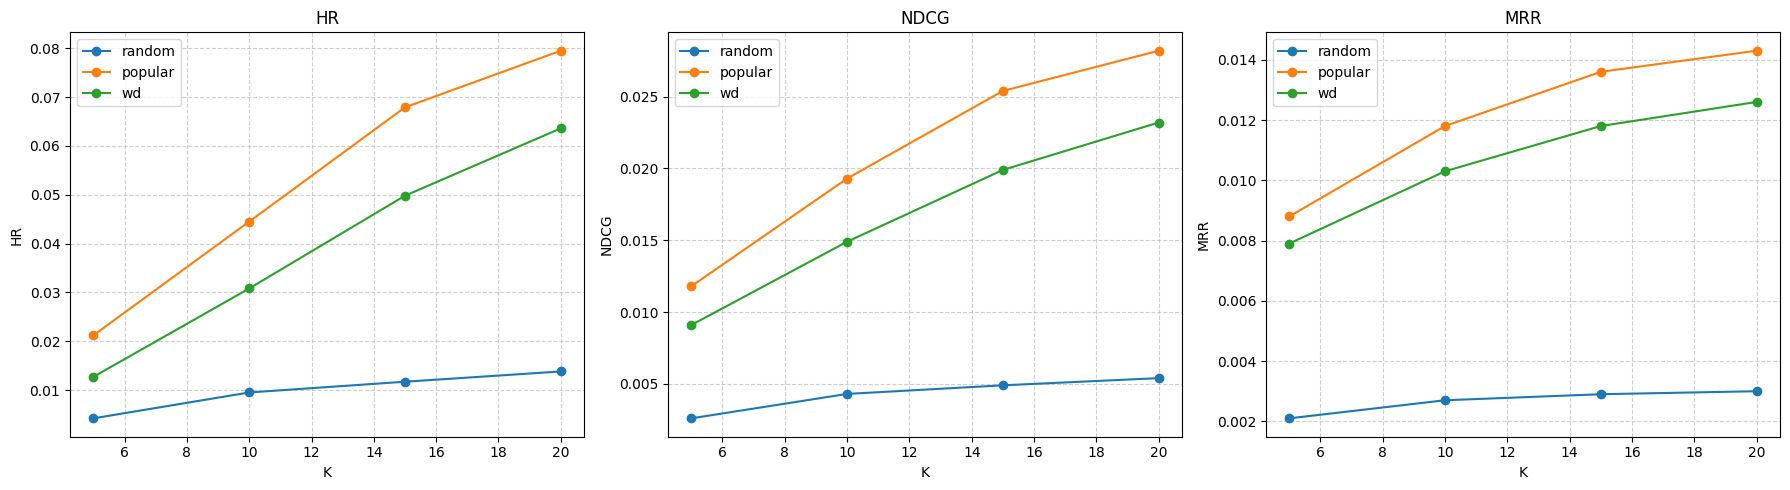

In [9]:
metrics = {"HR": hr, "NDCG": ndcg, "MRR": mrr}


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for ax, (metric_name, metric_dict) in zip(axes, metrics.items()):
    for m in experiment_group:
        values = [metric_dict[f"{m}@{k}"] for k in ks]
        ax.plot(ks, values, marker="o", label=m)

    ax.set_title(metric_name.upper())
    ax.set_xlabel("K")
    ax.set_ylabel(metric_name)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()